In [18]:
import numpy as np
import matplotlib.pyplot as plt

## Generate binary classification data with $p(x=1) = \frac{1}{1+e^{25.-0.5x}}$

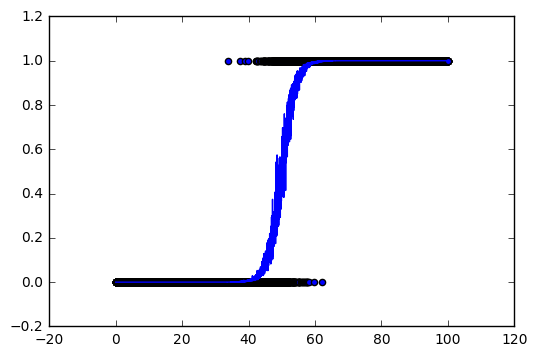

In [19]:
xi = 0.0
xf = 100.0
n = 10000

def logistic(beta,x):
    x = np.c_[np.ones_like(x), x]
    beta_x = (beta*x).sum(axis=1)  + np.random.randn(x.shape[0]) * 0.3
    return 1./(1. + np.exp(-beta_x))

beta = np.array([-25.,0.5])

x = np.linspace(xi,xf,n)

p = logistic(beta, x)

y = np.zeros_like(x)
for i in range(len(x)):
    if np.random.random() < p[i]:
        y[i] = 1.

Data = np.c_[x,y]
plt.scatter(x, y)
plt.plot(x, p)

Below, the $U(data, beta)$ is the potential energy. For logistic regression (binary, y = \{0,1\}), this is 
$$\sum_{x,y \in Data} log(1+e^{(-1)^y (\beta_0 + \beta_1 x_1 +\cdots)}) - log p(\mathbf{\beta})$$, the $p(\beta)$ is the prior distribution of $\beta$.

$gradU\_exact(data, beta)$ is the gradient of the potential energy. 
$$\frac{\partial U(\beta)}{\partial \beta_i} = \sum_{x,y \in Data} \frac{(-1)^y x_i }{1+e^{(-1)^{y+1} (\beta_0 + \beta_1 x_1 +\cdots)}} - \frac{\partial logp(\beta)}{\partial \beta_i}$$

$gradU\_SG(data, beta)$ uses only minibatch of the total data to compute the summation appearing in the gradient, plus a normal noise.

Here we are just using a uniform prior, i.e. $log(\beta) = 0$

In [20]:
from scipy.stats import multivariate_normal
# def U(data, beta):
#     dataX = data[:,:-1] 
#     dataY = data[:,-1]
#     dataX = np.c_[np.ones_like(dataX[:,0]), dataX]
#     beta_X = (beta*dataX).sum(axis=1)
#     pdata = (np.log(1. + np.exp( ((-1.)**dataY) * beta_X) )).sum() #log(p(data|beta)

#     mu = np.ones_like(beta)
#     sigma = np.eye(len(beta))
#     prior = -np.log(multivariate_normal.pdf(beta, mean=mu, cov=sigma) ) # prior distribution 
#     return pdata+prior


def U(data, beta):
    dataX = data[:,:-1] 
    dataY = data[:,-1]
    dataX = np.c_[np.ones_like(dataX[:,0]), dataX]
    beta_X = (beta*dataX).sum(axis=1)
    pdata = (np.log(1. + np.exp( ((-1.)**dataY) * beta_X) )).sum() #log(p(data|beta)
    
    #mu = np.zeros_like(beta)
    #sigma = np.eye(len(beta))    
    #prior =  0.5 * (beta-mu).dot(np.linalg.solve(sigma, beta-mu))#  log of prior distribution , discarding constant
    return pdata#+prior

def gradU_exact(data, beta):
    dataX = data[:,:-1] 
    dataY = data[:,-1]
    dataX = np.c_[np.ones_like(dataX[:,0]), dataX]
    beta_X = (beta*dataX).sum(axis=1)
    
    der_temp = ((-1.)**dataY)/(1. + (np.exp( ((-1.)**(dataY+1.)) * beta_X )) )
    ddata = (der_temp[:, None] * dataX).sum(axis=0)
    
    #mu = np.zeros_like(beta)
    #sigma = np.eye(len(beta))
    #dprior = np.linalg.solve(sigma, beta - mu)
    
    return ddata#+dprior

def gradU(data, minibatch, beta):
    '''using minibatch of the original data to compute the gradient'''
    
    dataX = data[:,:-1] 
    dataY = data[:,-1]
    dataX = np.c_[np.ones_like(dataX[:,0]), dataX]
    beta_X = (beta*dataX).sum(axis=1)
    
    der_temp = ((-1.)**dataY)/(1. + (np.exp( ((-1.)**(dataY+1.)) * beta_X )) )
    ddata = (der_temp[:, None] * dataX)
    ##### using minibatch of the data #####
    ddata = ddata[np.random.choice(ddata.shape[0], int(minibatch * ddata.shape[0]), replace=False),:].sum(axis=0) 
    #################################
    
    #mu = np.zeros_like(beta)
    #sigma = np.eye(len(beta))
    #dprior = np.linalg.solve(sigma, beta - mu)
    
    return (1./minibatch)*ddata#+dprior  #minibatch

In [21]:
import functools

gradU_data = functools.partial(gradU, Data)

U_data = functools.partial(U, Data)

### Doing a MLE for comparison

In [22]:
from scipy.optimize import minimize

minimize(U_data, [-20., 0.4])

      fun: 689.3915115175174
 hess_inv: array([[  8.16742953e-01,  -1.63183353e-02],
       [ -1.63183353e-02,   3.27947552e-04]])
      jac: array([  7.62939453e-06,  -7.62939453e-06])
  message: 'Optimization terminated successfully.'
     nfev: 48
      nit: 9
     njev: 12
   status: 0
  success: True
        x: array([-23.77231998,   0.47716436])

## Using SGHMC

In [23]:
def sghmc_vectorNew(gradU, eta, L, alpha, x, V):
    beta = 0.5 * V * eta
    p = np.random.randn(len(x)) * np.sqrt( eta )
    momentum = 1. - alpha
    try:
        sigma = np.sqrt( 2. * eta * (alpha-beta) )
    except:
        print('eta too big')
    for i in range(L):
        p = p * momentum - gradU( x ) * eta + np.random.randn(len(p)) * sigma
        x += p
    return x.copy()

In [25]:
nsample = 10000
minibatch = 0.1 # using 10% of the original data to compute gradient
gradU_data_SGHMC = functools.partial(gradU_data, minibatch)

V = 1./minibatch
etaSGHMC = (0.001)**2
alpha = 0.01
L = 50

In [26]:
samples = []
b = np.array([-1., 1])
for i in range(nsample):
    b = sghmc_vectorNew(gradU_data_SGHMC, etaSGHMC, L, alpha, b.copy(), V)
    samples.append(b)
    if i%1000 == 0:
        print(i, b)

0 [-3.5459978   1.47770221]
1000 [-24.42884407   0.53649363]
2000 [-25.26935268   0.5063979 ]
3000 [-26.112934     0.53595444]
4000 [-25.14404289   0.49370524]
5000 [-24.34667054   0.4820687 ]
6000 [-25.41977562   0.52384874]
7000 [-28.21438839   0.53650274]
8000 [-28.31941835   0.57887361]
9000 [-27.16010792   0.54865117]


(array([  280.,   771.,  1201.,   803.,   463.,   655.,   869.,  1574.,
         1061.,   323.]),
 array([-29.58395625, -29.01339958, -28.44284292, -27.87228626,
        -27.3017296 , -26.73117294, -26.16061627, -25.59005961,
        -25.01950295, -24.44894629, -23.87838962]),
 <a list of 10 Patch objects>)

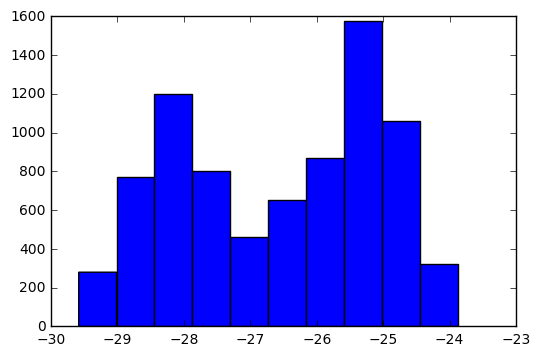

In [27]:
samples = np.array(samples)
plt.hist(samples[2000:,0])

(array([  1.40000000e+01,   2.31000000e+02,   1.44800000e+03,
          2.29000000e+03,   1.67500000e+03,   1.31400000e+03,
          8.28000000e+02,   1.77000000e+02,   2.10000000e+01,
          2.00000000e+00]),
 array([ 0.42704589,  0.4525059 ,  0.4779659 ,  0.50342591,  0.52888592,
         0.55434593,  0.57980594,  0.60526595,  0.63072596,  0.65618596,
         0.68164597]),
 <a list of 10 Patch objects>)

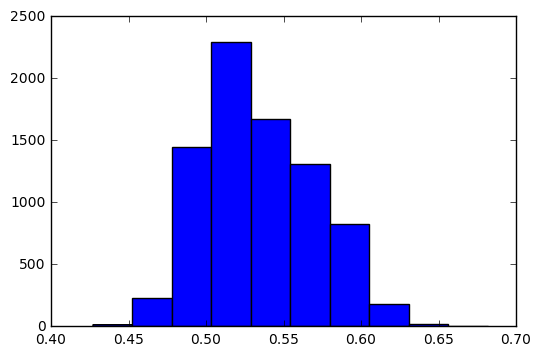

In [28]:
plt.hist(samples[2000:,1])

## Using HMC

In [29]:
def hmc_vector(U, gradU, m, dt, nstep, x, MH):
    p = np.random.randn(len(x)) * np.sqrt(m)
    oldX = x.copy()
    oldEnergy = 0.5 * (1./m) * p.dot(p)  + U(x)
    for i in range(nstep):
        p -= gradU(x) * dt/2.
        x +=  1./m * p * dt
        p -= gradU(x) * dt/2.
    newEnergy = 0.5 * (1./m) * p.dot(p)  + U(x)
    
    if MH and np.random.random() > np.exp(oldEnergy - newEnergy): # Metropolis-Hastings
        x = oldX.copy()
    return x.copy()

In [32]:
minibatch = 1.
gradU_data_HMC = functools.partial(gradU_data, minibatch)

nsample = 10000
m = 1.
dt = 0.001
nstep = 50
MH=False

In [33]:
samples = []
b = np.array([-1.,1.])
for i in range(nsample):
    b = hmc_vector( U_data, gradU_data_HMC, m, dt, nstep, b.copy(), MH )
    samples.append(b)
    if i%1000 == 0:
        print(i, b)
    

0 [-3.89937556  1.28398669]
1000 [-23.38818706   0.46700338]
2000 [-23.78577949   0.47689119]
3000 [-24.18051766   0.4834413 ]
4000 [-23.51425315   0.47196913]
5000 [-24.23170423   0.48843726]
6000 [-23.51786664   0.47087204]
7000 [-23.61017064   0.47301105]
8000 [-22.71697148   0.45535705]
9000 [-23.4280992    0.46876763]


(array([   88.,   375.,   805.,  1326.,  1447.,  1529.,  1224.,   733.,
          385.,    88.]),
 array([-25.33436627, -25.0184884 , -24.70261052, -24.38673265,
        -24.07085477, -23.75497689, -23.43909902, -23.12322114,
        -22.80734327, -22.49146539, -22.17558751]),
 <a list of 10 Patch objects>)

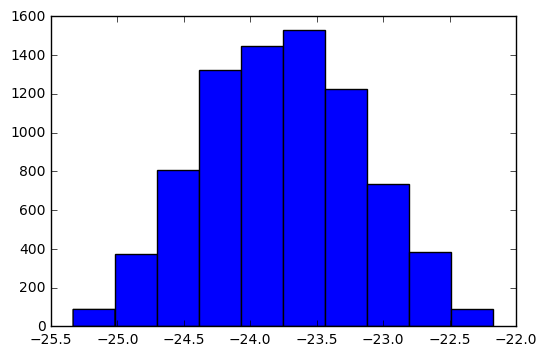

In [34]:
samples = np.array(samples)
plt.hist(samples[2000:,0])

(array([   96.,   398.,   725.,  1319.,  1489.,  1470.,  1330.,   760.,
          348.,    65.]),
 array([ 0.44504146,  0.45146056,  0.45787965,  0.46429875,  0.47071784,
         0.47713694,  0.48355603,  0.48997513,  0.49639422,  0.50281332,
         0.50923242]),
 <a list of 10 Patch objects>)

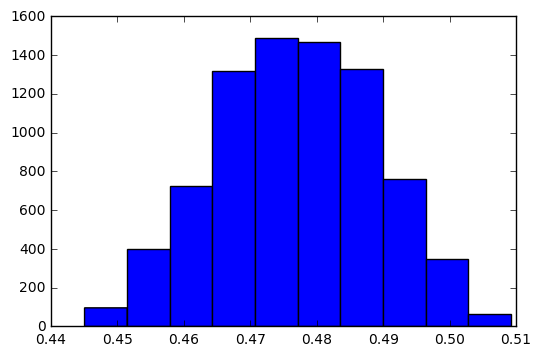

In [35]:
plt.hist(samples[2000:,1])

array([1, 2])